# IBPM Flow Experiments

Score-based data assimilation for IBPM cylinder flow data (Re=100)

In [ ]:
%load_ext autoreload
%autoreload 2

import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt

from pathlib import Path

from sda.mcs import *
from sda.score import *
from sda.utils import *

from experiments.ibpm.utils import *

## Helper Functions

In [2]:
def compute_vorticity(x):
    """Compute vorticity from velocity field (u, v)
    
    Args:
        x: (..., 2, H, W) - velocity field with channels [u, v]
        
    Returns:
        vorticity: (..., H, W) - vorticity field (∂v/∂x - ∂u/∂y)
    """
    u = x[..., 0, :, :]  # horizontal velocity
    v = x[..., 1, :, :]  # vertical velocity
    
    # Compute gradients using finite differences
    dvdx = torch.gradient(v, dim=-1)[0]  # ∂v/∂x
    dudy = torch.gradient(u, dim=-2)[0]  # ∂u/∂y
    
    vorticity = dvdx - dudy
    return vorticity


def plot_vorticity(w, title='Vorticity', vmin=-2.0, vmax=2.0, figsize=(15, 3)):
    """Plot vorticity field as image grid
    
    Args:
        w: (N, H, W) or (H, W) vorticity field
        title: Plot title
        vmin, vmax: Colormap range
        figsize: Figure size
    """
    if w.ndim == 2:
        w = w[None, ...]  # Add batch dimension
    
    n_samples = w.shape[0]
    fig, axes = plt.subplots(1, n_samples, figsize=figsize)
    
    if n_samples == 1:
        axes = [axes]
    
    for i in range(n_samples):
        im = axes[i].imshow(w[i], cmap='RdBu_r', vmin=vmin, vmax=vmax, origin='lower')
        axes[i].set_title(f't={i}')
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i], fraction=0.046)
    
    fig.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    return fig

## 1. Data Visualization

### 1.1 Train Data

In [3]:
# Load train data
with h5py.File('/workspace/data/ibpm_h5/train.h5') as f:
    train_data = torch.from_numpy(f['x'][:])
    print(f"Train data shape: {train_data.shape}")
    print(f"  - Samples: {train_data.shape[0]}")
    print(f"  - Timesteps per sample: {train_data.shape[1]}")
    print(f"  - Channels: {train_data.shape[2]} (u, v)")
    print(f"  - Spatial resolution: {train_data.shape[3]}×{train_data.shape[4]}")
    print(f"  - Data range: [{train_data.min():.3f}, {train_data.max():.3f}]")
    
# 軸の並び替え: (T, N, C, H, W) → (N, T, C, H, W)
train_data = train_data.permute(1, 0, 2, 3, 4).contiguous()

print("new shape:", train_data.shape)

Train data shape: torch.Size([16, 64, 2, 64, 64])
  - Samples: 16
  - Timesteps per sample: 64
  - Channels: 2 (u, v)
  - Spatial resolution: 64×64
  - Data range: [-0.832, 1.842]
new shape: torch.Size([64, 16, 2, 64, 64])


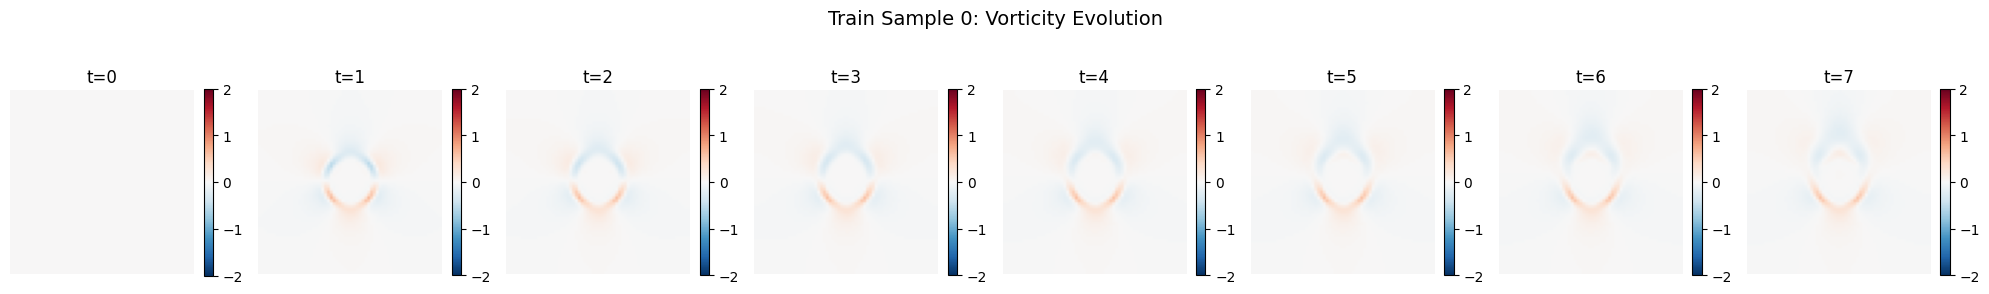

In [4]:
# Visualize first sample (8 timesteps)
sample_idx = 0
x_train = train_data[sample_idx, :8]  # (8, 2, 64, 64)

w_train = compute_vorticity(x_train)
fig = plot_vorticity(w_train, title=f'Train Sample {sample_idx}: Vorticity Evolution', figsize=(20, 3))
plt.savefig('ibpm_train_sample.png', dpi=150, bbox_inches='tight')
plt.show()

In [5]:
# 8ステップのうち前後差の大きさ
d = (x_train[1:] - x_train[:-1]).abs().mean(dim=(1,2,3))  # shape: (7,)
print("Δ(mean |u,v|) per step:", d.tolist())

# 最初と最後の差
d_end = (x_train[-1] - x_train[0]).abs().mean().item()
print("Δ(mean |u,v|) between t0 and t7:", d_end)

# 時間方向の分散（各画素・各成分での変化量）
var_t = x_train.float().var(dim=0).mean().item()
print("Var over time (u,v both):", var_t)

print("shape:", train_data.shape)      # 期待: (N, T, 2, 64, 64)
eq_to_t0 = [(train_data[0,t] - train_data[0,0]).abs().max().item() for t in range(train_data.shape[1])]
print("max|frame(t)-frame(0)|:", eq_to_t0)


Δ(mean |u,v|) per step: [0.14641769230365753, 0.0122037623077631, 0.011207759380340576, 0.011088312603533268, 0.011107495054602623, 0.011062235571444035, 0.010889694094657898]
Δ(mean |u,v|) between t0 and t7: 0.18624244630336761
Var over time (u,v both): 0.010357161052525043
shape: torch.Size([64, 16, 2, 64, 64])
max|frame(t)-frame(0)|: [0.0, 1.0871998071670532, 1.08768892288208, 1.086470603942871, 1.0853562355041504, 1.095789909362793, 1.1508150100708008, 1.206011176109314, 1.263783574104309, 1.3171348571777344, 1.360692024230957, 1.4015614986419678, 1.4262831211090088, 1.4498597383499146, 1.4632697105407715, 1.4725457429885864]


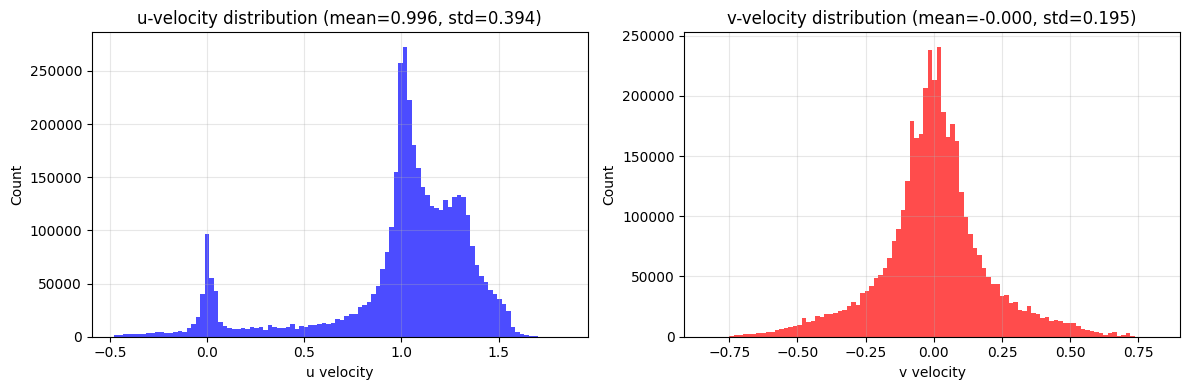

In [6]:
# Velocity statistics
u_train = train_data[:, :, 0].flatten()
v_train = train_data[:, :, 1].flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(u_train.numpy(), bins=100, alpha=0.7, color='blue')
axes[0].set_xlabel('u velocity')
axes[0].set_ylabel('Count')
axes[0].set_title(f'u-velocity distribution (mean={u_train.mean():.3f}, std={u_train.std():.3f})')
axes[0].grid(alpha=0.3)

axes[1].hist(v_train.numpy(), bins=100, alpha=0.7, color='red')
axes[1].set_xlabel('v velocity')
axes[1].set_ylabel('Count')
axes[1].set_title(f'v-velocity distribution (mean={v_train.mean():.3f}, std={v_train.std():.3f})')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('ibpm_train_velocity_stats.png', dpi=150, bbox_inches='tight')
plt.show()

### 1.2 Test Data

In [7]:
# Load test data
with h5py.File('/workspace/data/ibpm_h5/test.h5') as f:
    test_data = torch.from_numpy(f['x'][:])
    print(f"Test data shape: {test_data.shape}")
    print(f"  - Samples: {test_data.shape[0]}")
    print(f"  - Data range: [{test_data.min():.3f}, {test_data.max():.3f}]")

Test data shape: torch.Size([5, 64, 2, 64, 64])
  - Samples: 5
  - Data range: [-0.801, 1.563]


In [9]:
# Create SDE for sampling (use score.kernel like Kolmogorov)
window = 5
shape = torch.Size((window * 2, 128, 128))
sde = VPSDE(score.kernel, shape=shape).cuda()

# Sample trajectories
print("Sampling from learned distribution...")
x = sde.sample(torch.Size([4]), steps=64).cpu()
print(f"Generated samples shape: {x.shape}")  # (4, 10, 64, 64)

# Unflatten to (batch, timesteps, channels, H, W)
x = x.unflatten(1, (-1, 2))  # (4, 5, 2, 64, 64)

# Visualize each sample
for i in range(4):
    w = compute_vorticity(x[i])  # (5, 64, 64)
    fig = plot_vorticity(w, title=f'Unconditional Sample {i}', figsize=(15, 3))
    plt.savefig(f'ibpm_uncond_sample_{i}.png', dpi=150, bbox_inches='tight')
    plt.show()

NameError: name 'score' is not defined

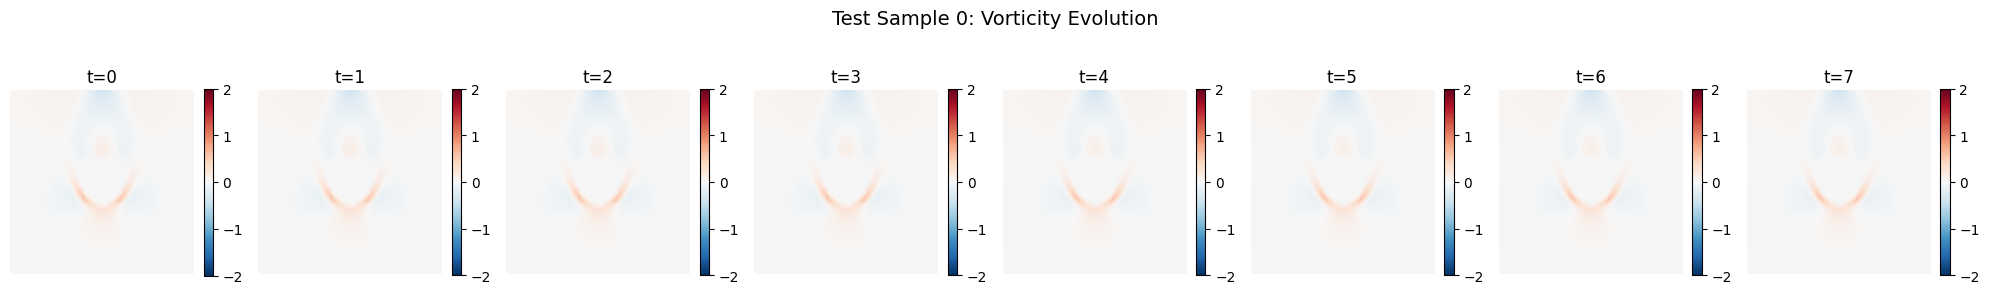

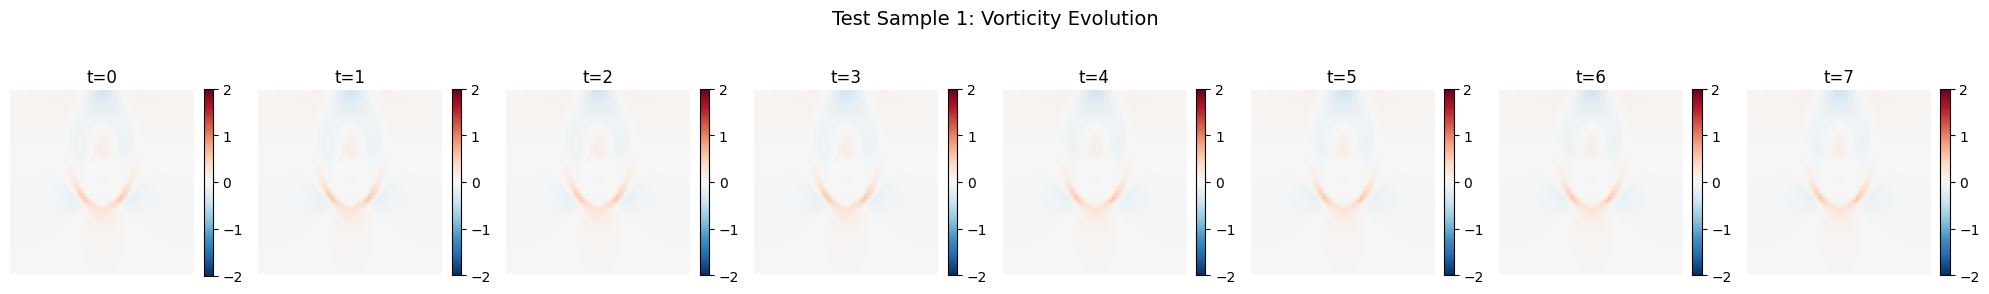

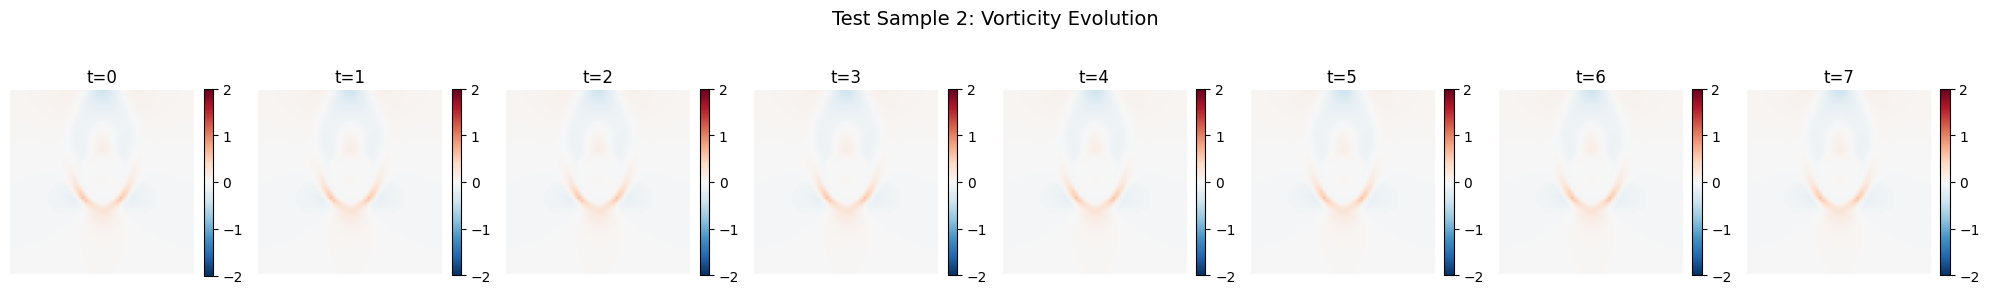

In [ ]:
# Visualize test samples
for sample_idx in range(min(3, test_data.shape[0])):
    x_test = test_data[sample_idx, :8]  # (8, 2, 64, 64)
    w_test = compute_vorticity(x_test)
    
    fig = plot_vorticity(w_test, title=f'Test Sample {sample_idx}: Vorticity Evolution', figsize=(20, 3))
    plt.savefig(f'ibpm_test_sample_{sample_idx}.png', dpi=150, bbox_inches='tight')
    plt.show()

## 2. Load Trained Model

In [ ]:
# Find the latest trained model
runs_dir = PATH / 'runs'
score_path = None

if runs_dir.exists():
    run_dirs = sorted(runs_dir.glob('*/state.pth'))
    if run_dirs:
        score_path = run_dirs[-1]  # Use latest
        print(f"Loading model from: {score_path}")
        score = load_score(score_path)
        print("✓ Model loaded successfully")
    else:
        print("✗ No trained models found. Please run train.py first.")
        print("  Command: python -m sda.experiments.ibpm.train")
else:
    print(f"✗ Runs directory not found: {runs_dir}")
    print("  Please train a model first.")

Loading model from: runs/wise-butterfly-5_c9nqeeq3/state.pth
✓ Model loaded successfully


## 3. Basic SDA Experiment

Unconditional sampling from learned distribution

In [ ]:
if score_path is not None:
    # Create SDE for sampling
    window = 5
    shape = torch.Size((window * 2, 64, 64))
    sde = VPSDE(score, shape=shape).cuda()
    
    # Sample trajectories
    print("Sampling from learned distribution...")
    x = sde.sample(torch.Size([4]), steps=64).cpu()
    print(f"Generated samples shape: {x.shape}")  # (4, 10, 64, 64)
    
    # Unflatten to (batch, timesteps, channels, H, W)
    x = x.unflatten(1, (-1, 2))  # (4, 5, 2, 64, 64)
    
    # Visualize each sample
    for i in range(4):
        w = compute_vorticity(x[i])  # (5, 64, 64)
        fig = plot_vorticity(w, title=f'Unconditional Sample {i}', figsize=(15, 3))
        plt.savefig(f'ibpm_uncond_sample_{i}.png', dpi=150, bbox_inches='tight')
        plt.show()

Sampling from learned distribution...


  0%|                                                            | 0/64 [00:00<?, ?it/s]

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 320 but got size 64 for tensor number 1 in the list.

## 4. Sparse Observation Reconstruction

Following Kolmogorov experiments with different subsampling rates

In [ ]:
if score_path is not None:
    # Use test data
    x_star = test_data[0, :8]  # (8, 2, 64, 64)
    
    # Ground truth
    w_star = compute_vorticity(x_star)
    fig = plot_vorticity(w_star, title='Ground Truth', figsize=(20, 3))
    plt.savefig('ibpm_sparse_ground_truth.png', dpi=150, bbox_inches='tight')
    plt.show()

### 4.1 Subsample by 2

In [ ]:
if score_path is not None:
    # Observation operator: subsample by 2
    def A(x):
        return x[..., ::2, ::2]
    
    # Create noisy observations
    y_star = torch.normal(A(x_star), 0.1)
    print(f"Observation shape: {y_star.shape}")  # (8, 2, 32, 32)
    
    # Reconstruct using SDA
    print("Reconstructing from sparse observations (subsample=2)...")
    sde = VPSDE(
        GaussianScore(
            y_star,
            A=A,
            std=0.1,
            sde=VPSDE(score, shape=()),
        ),
        shape=x_star.shape,
    ).cuda()
    
    x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
    w = compute_vorticity(x)
    
    fig = plot_vorticity(w, title='Reconstructed (subsample=2)', figsize=(20, 3))
    plt.savefig('ibpm_sparse_sub2_reconstructed.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Check reconstruction error
    error = (A(x) - y_star).std()
    print(f"Reconstruction error: {error:.4f} (should be ≈ 0.1)")

### 4.2 Subsample by 4

In [ ]:
if score_path is not None:
    # Observation operator: subsample by 4
    def A(x):
        return x[..., ::4, ::4]
    
    y_star = torch.normal(A(x_star), 0.1)
    print(f"Observation shape: {y_star.shape}")  # (8, 2, 16, 16)
    
    print("Reconstructing from sparse observations (subsample=4)...")
    sde = VPSDE(
        GaussianScore(
            y_star,
            A=A,
            std=0.1,
            sde=VPSDE(score, shape=()),
        ),
        shape=x_star.shape,
    ).cuda()
    
    x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
    w = compute_vorticity(x)
    
    fig = plot_vorticity(w, title='Reconstructed (subsample=4)', figsize=(20, 3))
    plt.savefig('ibpm_sparse_sub4_reconstructed.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    error = (A(x) - y_star).std()
    print(f"Reconstruction error: {error:.4f} (should be ≈ 0.1)")

### 4.3 Subsample by 8

In [ ]:
if score_path is not None:
    # Observation operator: subsample by 8
    def A(x):
        return x[..., ::8, ::8]
    
    y_star = torch.normal(A(x_star), 0.1)
    print(f"Observation shape: {y_star.shape}")  # (8, 2, 8, 8)
    
    print("Reconstructing from sparse observations (subsample=8)...")
    sde = VPSDE(
        GaussianScore(
            y_star,
            A=A,
            std=0.1,
            sde=VPSDE(score, shape=()),
        ),
        shape=x_star.shape,
    ).cuda()
    
    x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
    w = compute_vorticity(x)
    
    fig = plot_vorticity(w, title='Reconstructed (subsample=8)', figsize=(20, 3))
    plt.savefig('ibpm_sparse_sub8_reconstructed.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    error = (A(x) - y_star).std()
    print(f"Reconstruction error: {error:.4f} (should be ≈ 0.1)")

### 4.4 Subsample by 16

In [ ]:
if score_path is not None:
    # Observation operator: subsample by 16
    def A(x):
        return x[..., ::16, ::16]
    
    y_star = torch.normal(A(x_star), 0.1)
    print(f"Observation shape: {y_star.shape}")  # (8, 2, 4, 4)
    
    print("Reconstructing from sparse observations (subsample=16)...")
    sde = VPSDE(
        GaussianScore(
            y_star,
            A=A,
            std=0.1,
            sde=VPSDE(score, shape=()),
        ),
        shape=x_star.shape,
    ).cuda()
    
    x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
    w = compute_vorticity(x)
    
    fig = plot_vorticity(w, title='Reconstructed (subsample=16)', figsize=(20, 3))
    plt.savefig('ibpm_sparse_sub16_reconstructed.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    error = (A(x) - y_star).std()
    print(f"Reconstruction error: {error:.4f} (should be ≈ 0.1)")

## Summary

- ✓ Train/Test data visualization
- ✓ Unconditional sampling from learned distribution
- ✓ Sparse observation reconstruction (subsample=2,4,8,16)

All results saved to PNG files in the current directory.